# Neural Network V0.1 for Organic IR Spectroscopy

## Processing data

In [1]:
# Imports

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss


In [2]:
data = torch.load('../.pt')
X_values = data['X_values']
Y_values = data['Y_values']
Labels = data['Labels']


def preprocess_data(X_values, Y_values, Labels, cut_front=10, cut_end=10):
    """
    .pt file -> X_values, Y_values, Labels
    """
    # Trim the front and end of each spectrum
    processed_X = X_values[cut_front:-cut_end]
    processed_Y = Y_values[:, cut_front:-cut_end]

    # Create a mask for non-NaN rows and rows that are not all NaN
    mask = ~torch.isnan(processed_Y).all(dim=1) & ~torch.isnan(processed_Y).any(dim=1)

    # Apply the mask to Y_values and Labels
    processed_Y = processed_Y[mask]
    processed_Labels = Labels[mask]

    return processed_X, processed_Y, processed_Labels

# Example usage:
processed_X_values, processed_Y_values, processed_Labels = preprocess_data(X_values, Y_values, Labels)
print(f"Original X shape: {X_values.shape}, Processed X shape: {processed_X_values.shape}")
print(f"Original Y shape: {Y_values.shape}, Processed Y shape: {processed_Y_values.shape}")
print(f"Original labels: {Labels.shape}, Processed labels: {processed_Labels.shape}")



Original X shape: torch.Size([1000]), Processed X shape: torch.Size([980])
Original Y shape: torch.Size([141, 1000]), Processed Y shape: torch.Size([139, 980])
Original labels: torch.Size([141, 24]), Processed labels: torch.Size([139, 24])


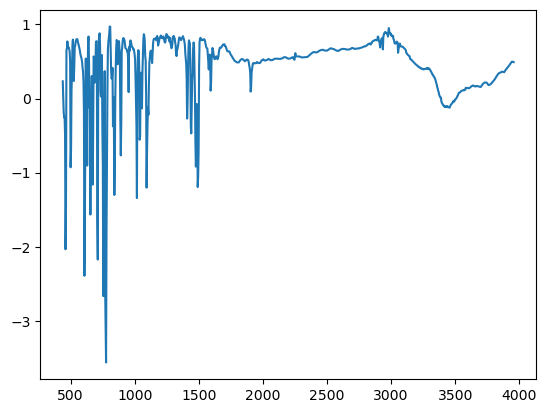

In [3]:
plt.plot(processed_X_values, processed_Y_values[2])

In [4]:
"""
Get Examples where label vectors are (LD) with others!! and make a test set out of them.
"""


def select_diverse_examples(processed_Y_values, processed_Labels, num_examples=10):
    num_samples = processed_Y_values.shape[0]
    num_labels = processed_Labels.shape[1]

    # Convert Labels to numpy for easier manipulation
    labels_np = processed_Labels.cpu().numpy()

    selected_indices = []
    remaining_indices = list(range(num_samples))

    while len(selected_indices) < num_examples and remaining_indices:
        if not selected_indices:
            # Select the first example randomly
            idx = np.random.choice(remaining_indices)
        else:
            # Calculate the Hamming distance to already selected examples
            distances = []
            for idx in remaining_indices:
                dist = [np.sum(labels_np[idx] != labels_np[sel_idx]) for sel_idx in selected_indices]
                distances.append(np.mean(dist))

            # Select the example with distance closest to the average
            avg_dist = np.mean(distances)
            idx = min(remaining_indices, key=lambda i: abs(distances[remaining_indices.index(i)] - avg_dist))

        selected_indices.append(idx)
        remaining_indices.remove(idx)

    # Create test set
    Y_test = processed_Y_values[selected_indices]
    Labels_test = processed_Labels[selected_indices]

    # Create train set (all indices not in selected_indices)
    train_indices = list(set(range(num_samples)) - set(selected_indices))
    Y_train = processed_Y_values[train_indices]
    Labels_train = processed_Labels[train_indices]

    return Y_train, Labels_train, Y_test, Labels_test

# Use the function to split the dataset
Y_train, Labels_train, Y_test, Labels_test = select_diverse_examples(processed_Y_values, processed_Labels)

# Training Set: Indices 0 to 399

print(f"Training set shape: {Y_train.shape}")
print(f"Training labels shape: {Labels_train.shape}")
print(f"Test set shape: {Y_test.shape}")
print(f"Test labels shape: {Labels_test.shape}")

# Verify that we have diverse examples in the test set
print("\nUnique label combinations in test set:")
for i in range(len(Labels_test)):
    print(f"Example {i+1}: {Labels_test[i].nonzero().squeeze().tolist()}")

Training set shape: torch.Size([129, 980])
Training labels shape: torch.Size([129, 24])
Test set shape: torch.Size([10, 980])
Test labels shape: torch.Size([10, 24])

Unique label combinations in test set:
Example 1: [1, 15, 23]
Example 2: 0
Example 3: [1, 4, 6, 23]
Example 4: [0, 13]
Example 5: [6, 7, 23]
Example 6: [6, 7, 13, 23]
Example 7: [7, 8, 23]
Example 8: [1, 15, 23]
Example 9: [7, 16, 23]
Example 10: [6, 7, 16, 23]


# NN 

In [172]:
class ImprovedNN(nn.Module):
    def __init__(self):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(980, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 24)
        
        self.ln1 = nn.LayerNorm(512)
        self.ln2 = nn.LayerNorm(256)
        self.ln3 = nn.LayerNorm(64)
        
        # He initialization
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.fc4.weight, nonlinearity='leaky_relu')

    def forward(self, x):
        x1 = F.leaky_relu(self.ln1(self.fc1(x)))
        x2 = F.leaky_relu(self.ln2(self.fc2(x1))) + x1  # Residual connection
        x3 = F.leaky_relu(self.ln3(self.fc3(x2)))
        out = self.fc4(x3)
        return out



In [173]:

# Create TensorDatasets
train_dataset = TensorDataset(Y_train, Labels_train)
test_dataset = TensorDataset(Y_test, Labels_test)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = NN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the GPU
model = model.to(device)

# Move data tensors to GPU
Labels_train = Labels_train.to(device)
Y_train = Y_train.to(device)
Labels_test = Labels_test.to(device)
Y_test = Y_test.to(device)

print("Model and data moved to GPU successfully.")

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()



The NN has: 653272 parameters
Using device: cuda
Model and data moved to GPU successfully.


/usr/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [181]:
#----// Training Loop //---------------------------

optimizer = optim.Adam(model.parameters(), lr=10e-4)

num_epochs = 1
epoch = 0
#for epoch in range(num_epochs):
while True:
    model.train()
    optimizer.zero_grad()
    outputs = model(Y_train)
    loss = criterion(outputs, Labels_train)
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

print(f"Training completed. Final loss: {loss.item()}")


Epoch [1/1], Loss: 3.848322549515615e-09
Epoch [1/1], Loss: 3.848675156348236e-09
Epoch [1/1], Loss: 3.8490282072700666e-09
Epoch [1/1], Loss: 3.849385254994786e-09
Epoch [1/1], Loss: 3.849748519968443e-09
Epoch [1/1], Loss: 3.850111340852891e-09
Epoch [1/1], Loss: 3.850471497202079e-09
Epoch [1/1], Loss: 3.850833429908107e-09
Epoch [1/1], Loss: 3.849747187700814e-09
Epoch [1/1], Loss: 3.848946494855454e-09
Epoch [1/1], Loss: 3.8483234376940345e-09
Epoch [1/1], Loss: 3.847867802164728e-09
Epoch [1/1], Loss: 3.847522744848675e-09
Epoch [1/1], Loss: 3.8472780516940475e-09
Epoch [1/1], Loss: 3.847126173184279e-09
Epoch [1/1], Loss: 3.8470409080559875e-09
Epoch [1/1], Loss: 3.8470115981681374e-09
Epoch [1/1], Loss: 3.8470289176473216e-09
Epoch [1/1], Loss: 3.847087537423022e-09
Epoch [1/1], Loss: 3.847190122030497e-09
Epoch [1/1], Loss: 3.847315355187675e-09
Epoch [1/1], Loss: 3.8474676777866534e-09
Epoch [1/1], Loss: 3.8476422048461245e-09
Epoch [1/1], Loss: 3.8478349395631994e-09
Epoch [

KeyboardInterrupt: 

In [204]:
def get_indices_above_threshold(vector, threshold):
    return [i for i, value in enumerate(vector) if value > threshold]

# Modified inference
model.eval()  # Set the model to evaluation mode
threshold = 0.5 # Increased threshold for more confident predictions

with torch.no_grad():  # Disable gradient calculation
    for i in range(10):  # Process 10 examples
        model_output = model(Y_test[i].unsqueeze(0)).squeeze()  # Add batch dimension and then remove it
        indices_above_threshold = get_indices_above_threshold(model_output, threshold)
        correct = get_indices_above_threshold(Labels_test[i], threshold)

        print(f"Example {i+1}:")
        print("Indices Predicted:", indices_above_threshold)
        print("Actual Indices:", correct)
        print()  # Add a blank line between examples for readability


Example 1:
Indices Predicted: [0, 6, 23]
Actual Indices: [1, 15, 23]

Example 2:
Indices Predicted: [5, 6, 23]
Actual Indices: [0]

Example 3:
Indices Predicted: [4, 6, 7, 16, 23]
Actual Indices: [1, 4, 6, 23]

Example 4:
Indices Predicted: [1, 11, 16]
Actual Indices: [0, 13]

Example 5:
Indices Predicted: [6, 7, 11, 23]
Actual Indices: [6, 7, 23]

Example 6:
Indices Predicted: [1, 6, 7, 9, 22, 23]
Actual Indices: [6, 7, 13, 23]

Example 7:
Indices Predicted: [7, 8, 11, 22, 23]
Actual Indices: [7, 8, 23]

Example 8:
Indices Predicted: [1]
Actual Indices: [1, 15, 23]

Example 9:
Indices Predicted: [23]
Actual Indices: [7, 16, 23]

Example 10:
Indices Predicted: [1, 4, 6, 7, 23]
Actual Indices: [6, 7, 16, 23]



In [201]:
def evaluate_model_accuracy(model, X_values, y_true, threshold=0.5):
    model.eval()
    total_correct = 0
    total_predicted = 0
    total_actual = 0

    with torch.no_grad():
        for i in range(len(X_values)):
            model_output = model(X_values[i].unsqueeze(0)).squeeze()
            predicted_indices = set(get_indices_above_threshold(model_output, threshold))
            actual_indices = set(get_indices_above_threshold(y_true[i], threshold))

            correct = predicted_indices.intersection(actual_indices)
            total_correct += len(correct)
            total_predicted += len(predicted_indices)
            total_actual += len(actual_indices)

    precision = total_correct / total_predicted if total_predicted > 0 else 0
    recall = total_correct / total_actual if total_actual > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.4f}(Positive guesses/inverse Proportional to false positive rate)")
    print(f"Recall: {recall:.4f} (Negative Guesses/Inverse Proportional to false negative rate.)")
    print(f"F1 Score: {f1_score:.4f}(total performance!)")

    return precision, recall, f1_score

# Usage
precision, recall, f1_score = evaluate_model_accuracy(model, Y_test, Labels_test)

Precision: 0.5000(Positive guesses/inverse Proportional to false positive rate)
Recall: 0.6000 (Negative Guesses/Inverse Proportional to false negative rate.)
F1 Score: 0.5455(total performance!)


# DocTools

layer 0: mean -0.83, std 55.87
layer 1: mean -0.34, std 0.54
layer 2: mean -0.56, std 3.99
layer 3: mean -0.27, std 0.63
layer 4: mean 0.28, std 1.86
layer 5: mean 0.81, std 2.18
layer 6: mean -31.05, std 17.67


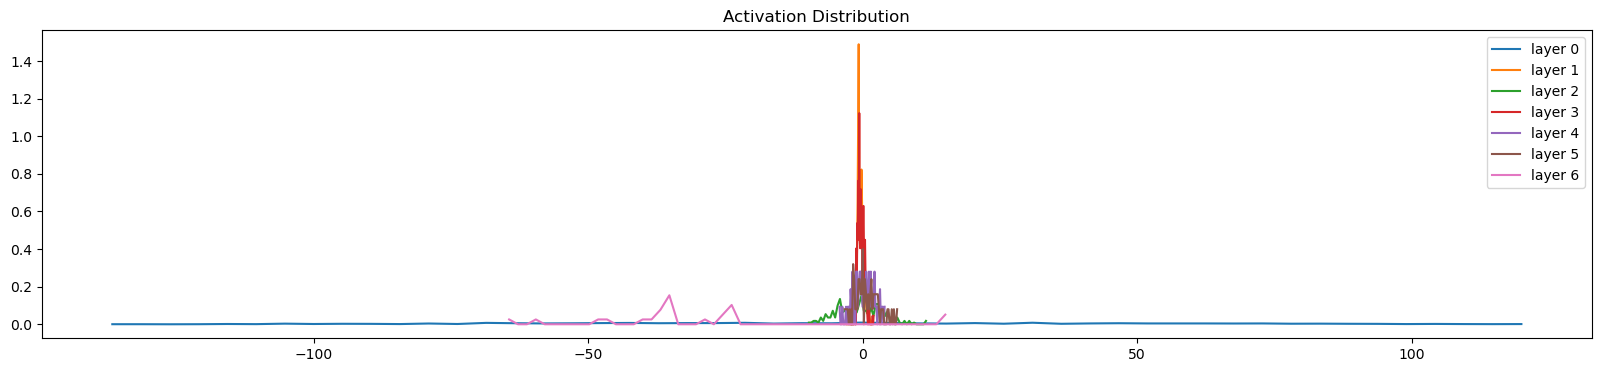

In [185]:
# DocTools

import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_activations(model, input_data):
    model.eval()
    activations = []
    
    def hook(module, input, output):
        activations.append(output.detach())
    
    # Register hooks for each layer
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Linear, torch.nn.BatchNorm1d, torch.nn.ReLU)):
            hooks.append(module.register_forward_hook(hook))
    
    # Forward pass
    with torch.no_grad():
        model(input_data)
    
    # Remove hooks
    for h in hooks:
        h.remove()
    
    # Visualize histograms
    plt.figure(figsize=(20, 4))
    legends = []
    
    for i, activation in enumerate(activations):
        if activation.dim() > 2:
            activation = activation.view(activation.size(0), -1)
        
        t = activation.view(-1).cpu().numpy()
        print(f'layer {i}: mean {np.mean(t):.2f}, std {np.std(t):.2f}')
        
        hist, bin_edges = np.histogram(t, bins=50, density=True)
        plt.plot(bin_edges[:-1], hist)
        legends.append(f'layer {i}')
    
    plt.legend(legends)
    plt.title('Activation Distribution')
    plt.show()

# Usage
# Assuming you have your model and a sample input
sample_input = Y_train[:1]  # Use the first training sample
visualize_activations(model, sample_input)

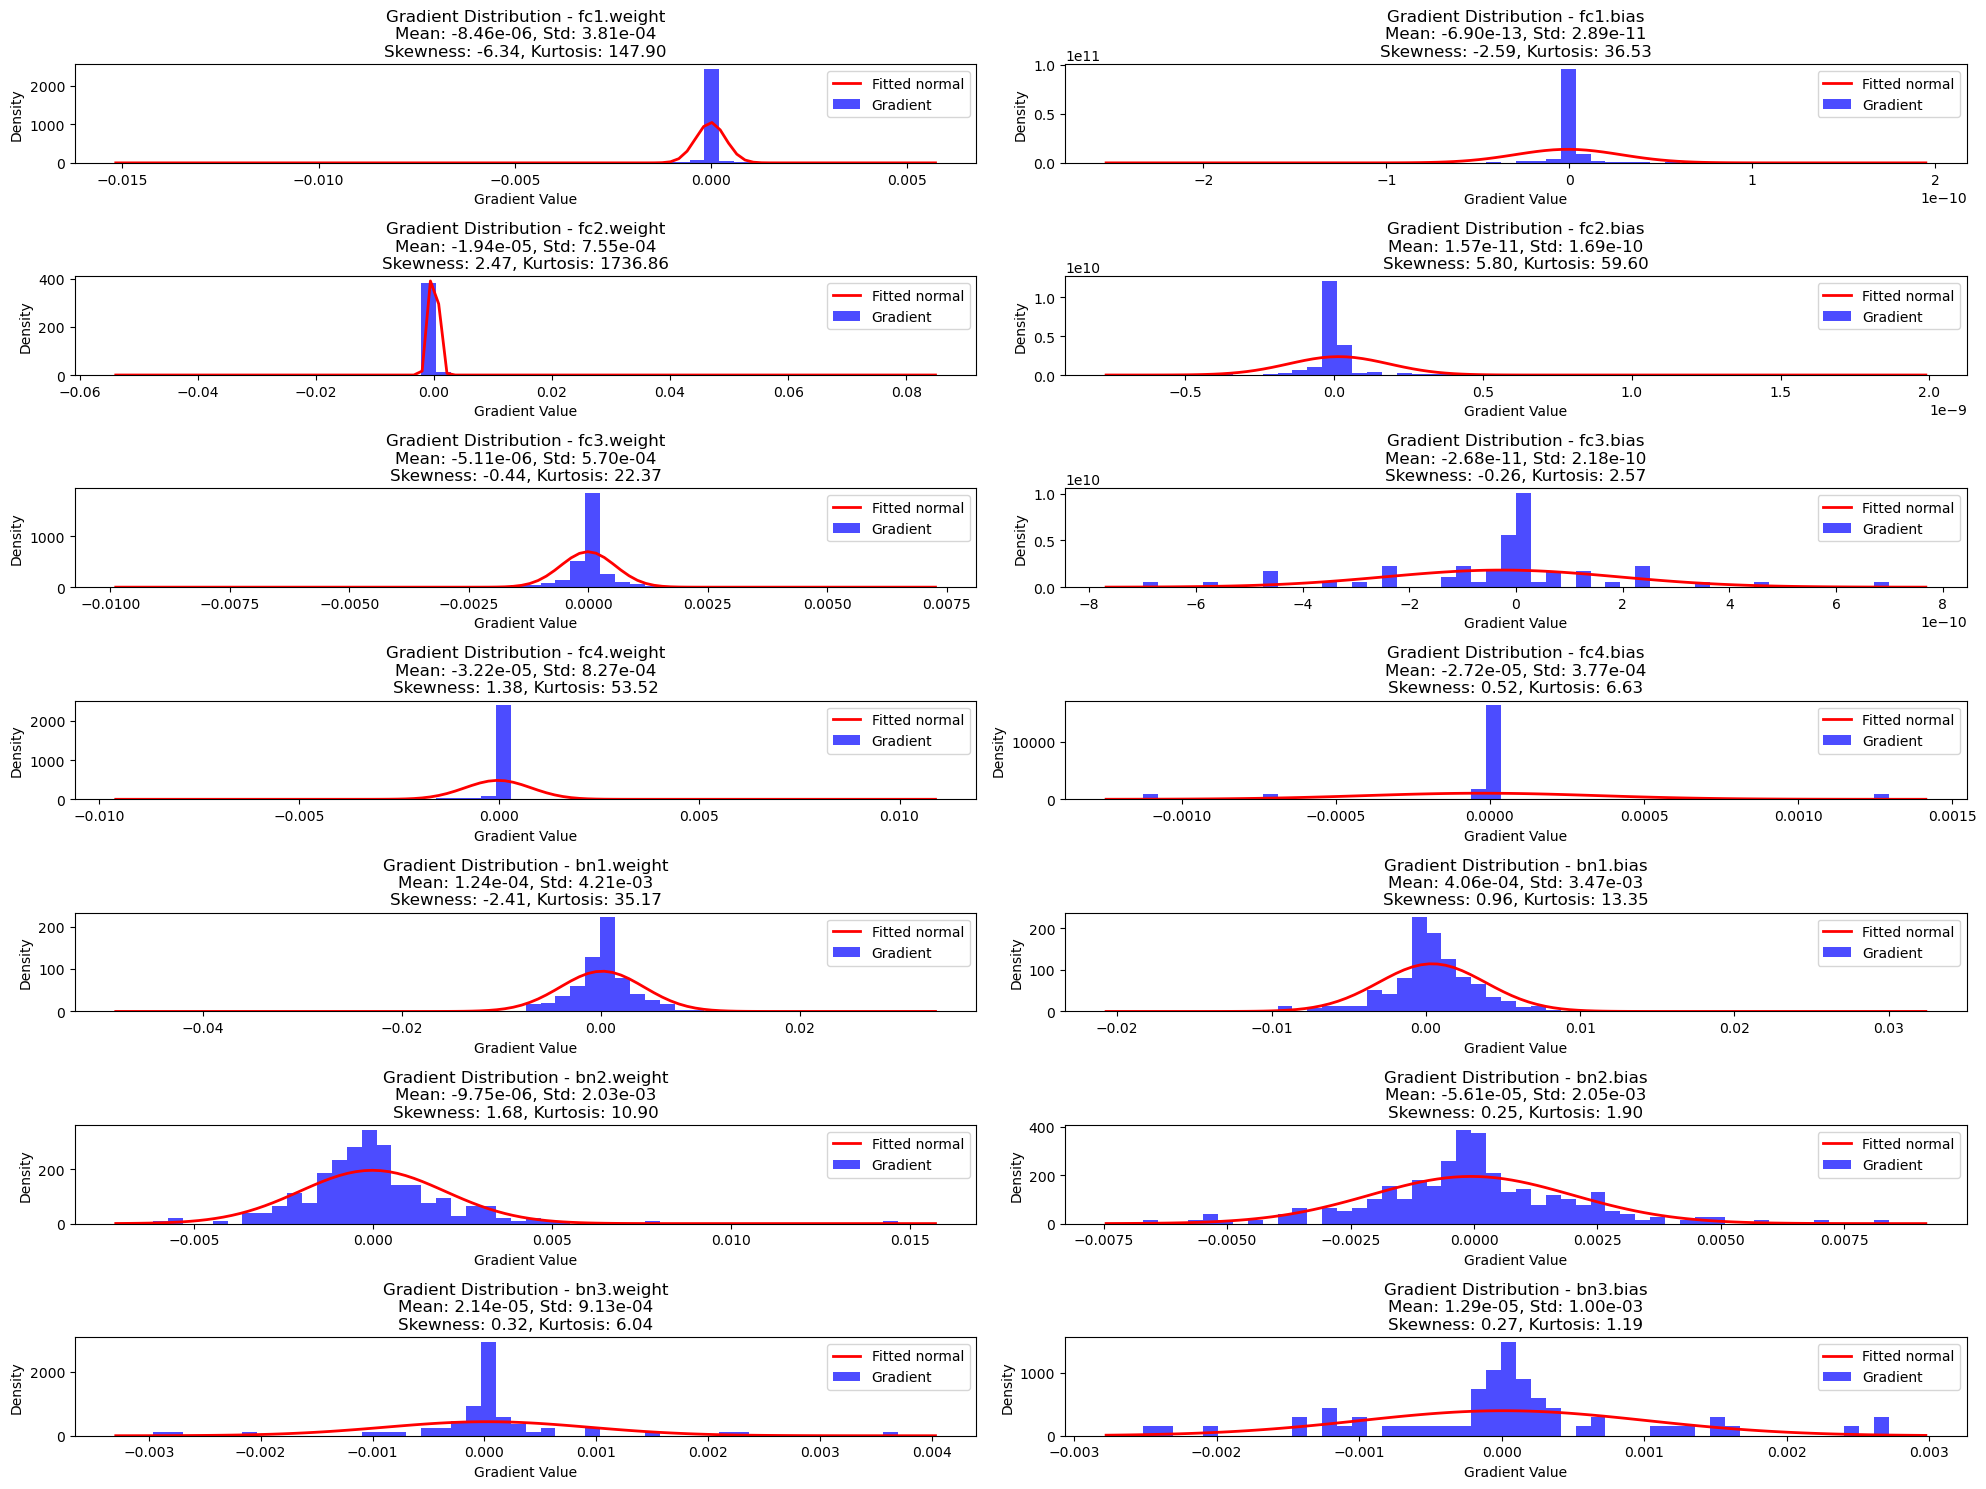

In [191]:
def visualize_gradients(model, criterion, input_data, labels, device):
    model.train()  # Set model to training mode
    model.zero_grad()  # Clear previous gradients
    
    # Move input data and labels to the specified device
    input_data = input_data.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = model(input_data)
    loss = criterion(outputs, labels)
    
    # Backward pass
    loss.backward()
    
    plt.figure(figsize=(20, 15))  # Increased figure size
    
    num_params = sum(1 for param in model.parameters() if param.requires_grad)
    rows = (num_params + 1) // 2  # Calculate number of rows needed
    
    for i, (name, param) in enumerate(model.named_parameters()):
        if param.grad is not None:
            grad = param.grad.cpu().detach().numpy().flatten()
            
            plt.subplot(rows, 2, i+1)  # Create subplots dynamically based on number of parameters
            
            # Plot histogram of gradients
            n, bins, _ = plt.hist(grad, bins=50, density=True, alpha=0.7, color='b')
            
            # Fit a normal distribution to the data
            mu, std = stats.norm.fit(grad)
            
            # Plot the PDF of the fitted normal distribution
            xmin, xmax = plt.xlim()
            x = np.linspace(xmin, xmax, 100)
            p = stats.norm.pdf(x, mu, std)
            plt.plot(x, p, 'r', linewidth=2)
            
            # Calculate additional statistics
            skewness = stats.skew(grad)
            kurtosis = stats.kurtosis(grad)
            
            plt.title(f'Gradient Distribution - {name}\n'
                      f'Mean: {mu:.2e}, Std: {std:.2e}\n'
                      f'Skewness: {skewness:.2f}, Kurtosis: {kurtosis:.2f}')
            plt.xlabel('Gradient Value')
            plt.ylabel('Density')
            plt.legend(['Fitted normal', 'Gradient'])
    
    plt.tight_layout()
    plt.show()

# Usage
sample_input = Y_train[:32].to(device)  # Use a batch of training samples
sample_labels = Labels_train[:32].to(device)
criterion = nn.BCEWithLogitsLoss()  # Make sure this matches your loss function

visualize_gradients(model, criterion, sample_input, sample_labels, device)

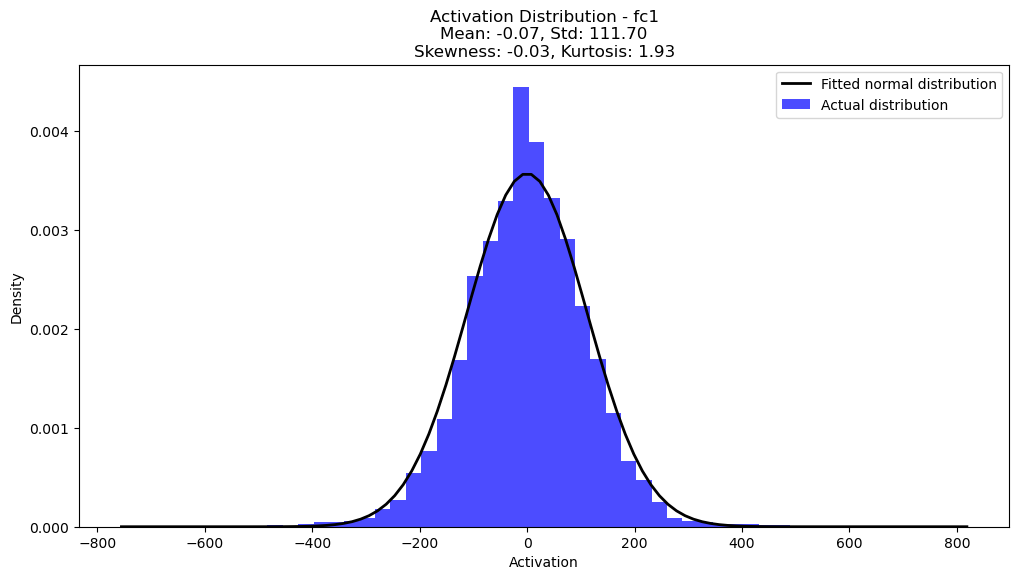

fc1:
  Mean: -0.0705
  Standard Deviation: 111.6988
  Skewness: -0.0323
  Kurtosis: 1.9318



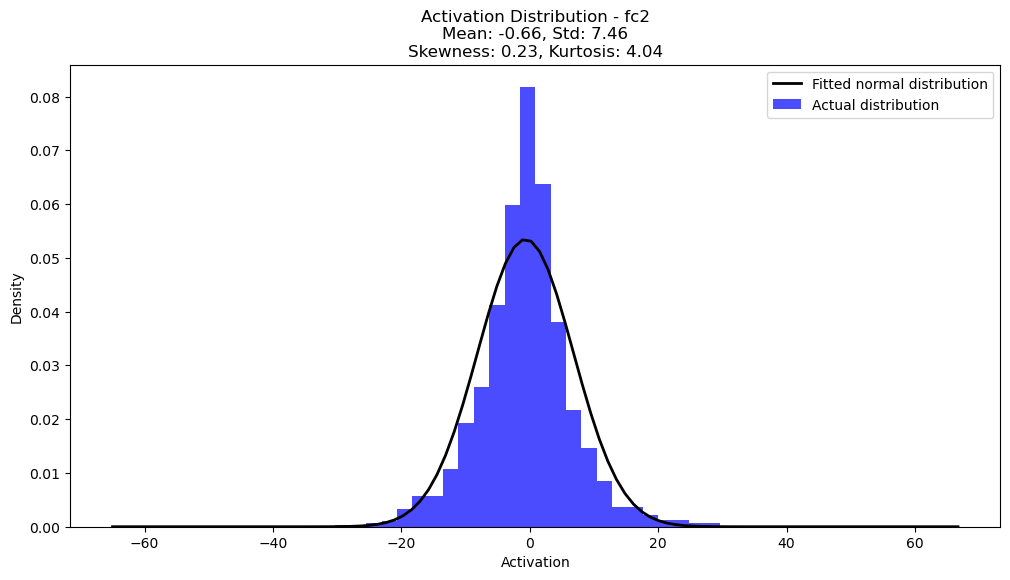

fc2:
  Mean: -0.6589
  Standard Deviation: 7.4598
  Skewness: 0.2301
  Kurtosis: 4.0428



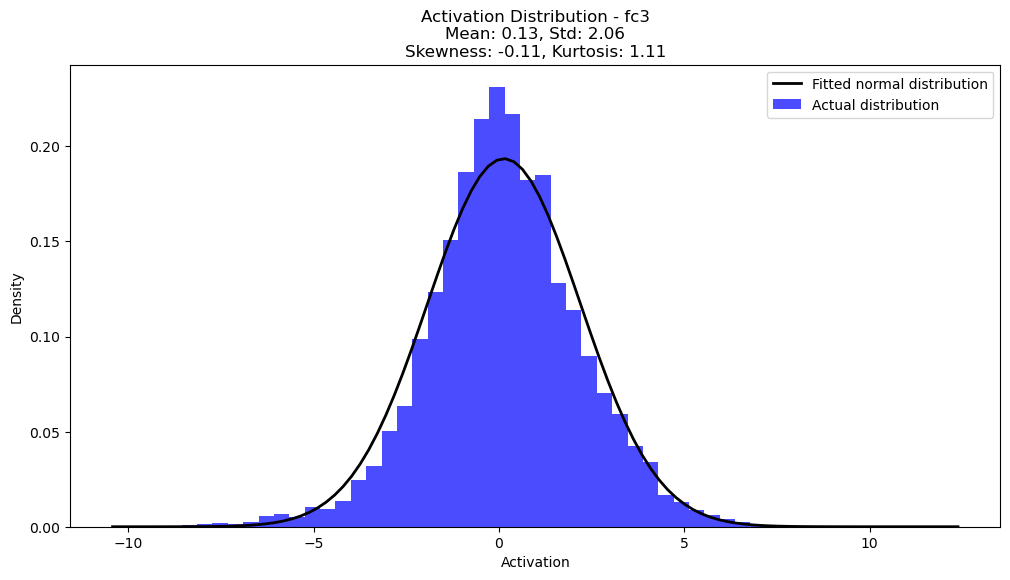

fc3:
  Mean: 0.1328
  Standard Deviation: 2.0611
  Skewness: -0.1085
  Kurtosis: 1.1060



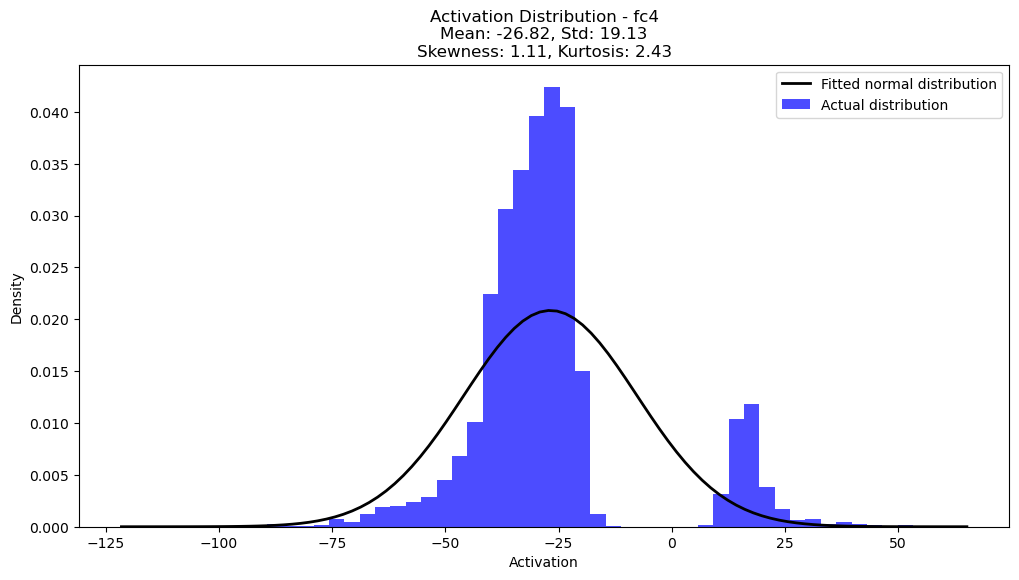

fc4:
  Mean: -26.8170
  Standard Deviation: 19.1295
  Skewness: 1.1119
  Kurtosis: 2.4257



In [193]:
def visualize_activation_distribution(model, dataloader, device):
    model.eval()
    activations = {name: [] for name, _ in model.named_modules() if isinstance(_, nn.Linear)}
    
    def hook(name):
        def fn(_, __, output):
            activations[name].append(output.detach())
        return fn
    
    # Register hooks
    handles = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            handles.append(module.register_forward_hook(hook(name)))
    
    # Forward pass through the data
    with torch.no_grad():
        for batch, _ in dataloader:
            batch = batch.to(device)
            model(batch)
    
    # Remove hooks
    for handle in handles:
        handle.remove()
    
    # Process activations
    for name, acts in activations.items():
        acts = torch.cat(acts, dim=0).cpu().numpy().flatten()
        
        plt.figure(figsize=(12, 6))
        
        # Plot histogram of activations
        n, bins, _ = plt.hist(acts, bins=50, density=True, alpha=0.7, color='b')
        
        # Fit a normal distribution to the data
        mu, std = stats.norm.fit(acts)
        
        # Plot the PDF of the fitted normal distribution
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth=2)
        
        # Calculate skewness and kurtosis
        skewness = stats.skew(acts)
        kurtosis = stats.kurtosis(acts)
        
        plt.title(f'Activation Distribution - {name}\n'
                  f'Mean: {mu:.2f}, Std: {std:.2f}\n'
                  f'Skewness: {skewness:.2f}, Kurtosis: {kurtosis:.2f}')
        plt.xlabel('Activation')
        plt.ylabel('Density')
        plt.legend(['Fitted normal distribution', 'Actual distribution'])
        plt.show()
        
        print(f'{name}:')
        print(f'  Mean: {mu:.4f}')
        print(f'  Standard Deviation: {std:.4f}')
        print(f'  Skewness: {skewness:.4f}')
        print(f'  Kurtosis: {kurtosis:.4f}')
        print()

# Usage
batch_size = 64
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
visualize_activation_distribution(model, dataloader, device)

# Testing on Real Data!!

In [ ]:
def get_indices_above_threshold(vector, threshold):
    return (vector > threshold).nonzero(as_tuple=True)[0].cpu().numpy()

def process_example(model, device, threshold=0.5):
    """
    Processes the example.pt file using the provided model.
    """
    # Load the example data
    example = torch.load('example.pt', weights_only=True)  # Add weights_only=True to address the warning
    y_example = example[:, 1]  # Shape: (980,)

    # Convert to float32 and move tensor to the specified device
    y_example = y_example.to(device).float()

    # Reshape y_example to match the model's expected input
    y_example = y_example.unsqueeze(0)  # Shape: (1, 980)

    with torch.no_grad():
        model_output = model(y_example)
        indices_above_threshold = get_indices_above_threshold(model_output.squeeze(), threshold)
        print("Indices Predicted:", indices_above_threshold)


process_example(nn_model, device)

NameError: name 'nn_model' is not defined

# Saving the model!!

In [ ]:
# Export the model for future training
torch.save({
    'model_state_dict': nn_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item()
}, 'ir_model_checkpoint_(4L)_(L2)_v1.pth')

print("Model saved successfully for future training.")


Model saved successfully for future training.


In [ ]:
# Assuming you have defined your model architecture (nn_model) beforehand

# Load the checkpoint
checkpoint = torch.load('ir_model_checkpoint_(4L)_(L2)_v1.pth')

# Load the model state dictionary
nn_model.load_state_dict(checkpoint['model_state_dict'])

# If you want to continue training, you can also load the optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Set the model to evaluation mode if you're using it for inference
#nn_model.eval()

print("Model loaded successfully.")

<ipython-input-10-2989b3f7ce80>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('ir_model_checkpoint_(4L)_(L2)_v1.pth')


Model loaded successfully.
